- Matteo Migliarini
- Flavio Brizzolari
- Davit Gevorgyan

# 1. Finding Similar Costumers
---

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import random
from collections import defaultdict
from functions import *

# 1.1 Set up the data

 First thing we need to do is download the dataset and have a look at it.

In [ ]:
transactions = r'bank_transactions.csv'
bank = pd.read_csv(transactions, delimiter=',')
bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0


 We can see that is is comprised of more than 1 milion rows and 9 columns, take a further look.

In [3]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


 We see that of what type all our elements really are, so we will have to change a few things, like looking at missing values.

In [4]:
bank.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

I can see that diffferent columns have multiple Na's, my approach is that of:  

- transforming Na's to 0 in the customer Account Balance, because i would imagine, the balance would be low for this an Na appeared.  

- changing the Na's in CustGender randomly to M or F, this is based on the assumption that the CustomerID is refered to a bankaccount where multiple can access it, so to not change the overall percentages of Male and Female we have decided to assign randomly the M and F to our dataset

- dropping Na's in the other columns

In [5]:
#for the moment dropping also gender
bank = bank.dropna(subset=['CustomerDOB','CustLocation','CustGender'])
bank['CustAccountBalance'].fillna(0,inplace=True)
bank.drop(bank.index[bank['CustGender'] == 'T'], inplace = True)
bank.isna().sum()

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

 Looking at the Date of Birth we see some inconsistencies.

In [6]:
bank['CustomerDOB'].value_counts()

1/1/1800    56465
1/1/89        809
1/1/90        784
6/8/91        699
1/1/91        666
            ...  
17/8/59         1
18/3/69         1
4/6/51          1
1/3/35          1
30/5/33         1
Name: CustomerDOB, Length: 17253, dtype: int64

Different people born in 1800 and some dates without the full year so first we drop the 1800 because we wouldn't know what year to assign and then we reshape the years of this column, we also found people born after 2020 so we decided to change those taking away 100 years believing that they where from older people with maybe difficulties working the computer.

In [7]:
bank = bank.drop(bank[bank['CustomerDOB'] == '1/1/1800'].index,axis = 0)
bank['CustomerDOB'] = pd.to_datetime(bank['CustomerDOB'])
bank.loc[bank.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = bank.loc[bank.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

In [8]:
bank['CustomerDOB'].value_counts()

1989-01-01    809
1990-01-01    784
1991-06-08    699
1991-01-01    666
1992-01-01    633
             ... 
1952-06-18      1
1950-07-11      1
1932-04-04      1
1939-12-10      1
2000-04-10      1
Name: CustomerDOB, Length: 17252, dtype: int64

Let's change also the Transaction time to an workable element

In [9]:
bank['TransactionDate'] = pd.to_datetime(bank['TransactionDate'])
bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5


 we won't do the same with the transaction time as the queries use the predefinite version of the dataset for the time.

In [10]:
bank['TransactionAmount (INR)'].value_counts()

100.00     33238
50.00      30189
200.00     30093
500.00     27012
1000.00    20511
           ...  
1821.04        1
124.60         1
339.82         1
2570.65        1
738.50         1
Name: TransactionAmount (INR), Length: 86936, dtype: int64

looking at transaction amounts maybe the best thing is to omit the cents so that we can work with only int values:

In [11]:
bank['TransactionAmount (INR)'] = bank['TransactionAmount (INR)'].astype(int)
bank['TransactionAmount (INR)'].value_counts()

100      33757
50       30358
200      30208
500      27074
1000     20568
         ...  
18810        1
10614        1
14034        1
9239         1
7233         1
Name: TransactionAmount (INR), Length: 17382, dtype: int64

 It is time to create a new dataset containing only the columns we need, we use those columns that are present in the query.

In [12]:
new_bank = bank[["CustomerDOB","CustGender","CustLocation","CustAccountBalance","TransactionDate","TransactionTime","TransactionAmount (INR)"]]
new_bank.reset_index(drop=True, inplace = True)
new_bank.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25
1,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999
2,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459
3,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060
4,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762


In [13]:
new_bank.rename(columns = {"TransactionAmount (INR)":"TransactionAmount_INR"}, inplace = True)
new_bank.head(20)

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount_INR
0,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25
1,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999
2,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459
3,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060
4,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762
5,1972-08-10,F,ITANAGAR,53609.20,2016-02-08,173940,676
6,1992-01-26,F,MUMBAI,973.46,2016-02-08,173806,566
7,1982-01-27,M,MUMBAI,95075.54,2016-02-08,170537,148
8,1988-04-19,F,GURGAON,14906.96,2016-02-08,192825,833
9,1984-06-22,M,MUMBAI,4279.22,2016-02-08,192446,289


In [14]:
new_bank.isna().sum()

CustomerDOB              0
CustGender               0
CustLocation             0
CustAccountBalance       0
TransactionDate          0
TransactionTime          0
TransactionAmount_INR    0
dtype: int64

In [15]:
new_bank.to_csv('bank_clean.csv', index=False)

# 1.2 fingerprint hashing

In [16]:
new_bank = pd.read_csv('bank_clean.csv', parse_dates=['TransactionDate', 'CustomerDOB'])

In [17]:
new_bank['CustomerDOB'] = new_bank['CustomerDOB'].astype(int)
new_bank['TransactionDate'] = new_bank['TransactionDate'].astype(int)
new_bank.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount_INR
0,780969600000000000,F,JAMSHEDPUR,17819.05,1454889600000000000,143207,25
1,-402192000000000000,M,JHAJJAR,2270.69,1454889600000000000,141858,27999
2,848966400000000000,F,MUMBAI,17874.44,1454889600000000000,142712,459
3,116812800000000000,F,MUMBAI,866503.21,1454889600000000000,142714,2060
4,575164800000000000,F,NAVI MUMBAI,6714.43,1454889600000000000,181156,1762


In this graph we can see that a lot of the locations aren't very frequent and that the majority of the density is in a very small subgroup, so in our pipeline we will use min_frequency giving us the possibility to group in bins certain values

<AxesSubplot: ylabel='Density'>

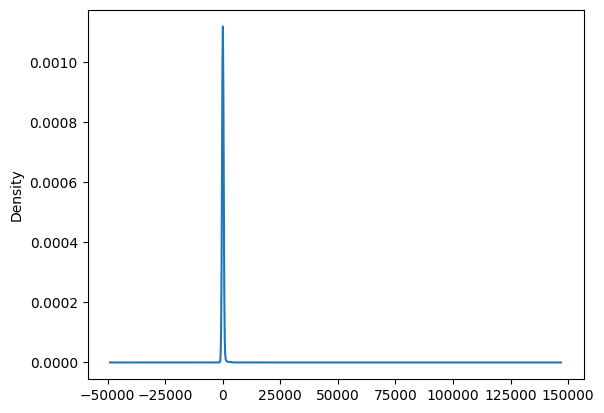

In [38]:
pop_places = new_bank['CustLocation'].value_counts(sort=False)
pop_places.plot(kind='kde')

 we created a pipeline for our one hot matrix transformation.
 the transformation had to be done separately for the numerical columns and the categorical columns, we decided to create a pipeline that could fit also non cleaned dataframes, so we inserted an 'imputer' that fills eventual Na's with a value ('median' for the caterogical values, 'most frequent' for the numerical values).  
 in output we get a sparse matrix, it's a matrix omitted of all the zeros and preserving only the position for each non-zero value in the matrix. It helps computationally to facilitate the work

In [20]:
sm, pipeline = shingles_matrix_fit(new_bank,['CustGender','CustLocation'],
['CustomerDOB','CustAccountBalance','TransactionDate','TransactionTime','TransactionAmount_INR'],30)

In [21]:
sm.shape

(995, 987516)

 we can see here that it returns a matrix of 995 rows, which are our single shingles without repetition, and about a milion columns, which are each indipendent transaction.

 we create a hash function that will mimic pseudo-randomness

In [22]:
from functions import r_hash

Now our function that, given a dataset, will transform it into a signature matrix. This function will work for both our dataset and our query. 

In [23]:
def signature_matrix(shingle_matrix, hashes, N_cols):
    # shingle_matrix = a matrix with unique shingles for every document
    # hashes = the hash functions to apply to our shingles matrix
    # N_cols = number of columns in our matrix
    
    # in the scipy sparse matrix the indices represent an array of the positions in increasing order
    # on each column of the the non zero values, without taking in account the rows.
    nnz = shingle_matrix.indices

    # by reshaping the indices to get everytime a single transaction, we performed K hash functions
    # to mimic pseudo-randomness and a permutation by getting in this way a three-dimensional matrix where 
    # rows: are the positions of the ones in the shingle matrix
    # columns: the transactions
    # depth: the number of hash functions of our minhash
    hash_idx = np.stack([hash(nnz).reshape((-1,N_cols)) for hash in hashes])

    # with matrix.min(axis=2) we go through the third dimension, so the depth
    # and we choose the minimum everytime that will give us the first time a one comes up
    # in every hash function, so we do the over all the depth giving us the signature for every transaction
    signature = hash_idx.min(axis=2)
    
    return signature

Create a dictionary where we will store our B bands in N bins, where the N of the bins is not decided by us but by the occurences that we will have in our transactions

**we put all our functions together for our minhash function, where we can tune:**
  
- K = number of hash functions to apply  
- Bands_len = the length of every Bands_len  
- num_bins = the number of bins for our pipeline NOT the bins for our minhash, which are random based on width of the bands and number of documents

we set a seed for reproducibility. 
Given that we chose 20 hash functions because it returned the best efficiency based on time, the question now is: how do we choose the bands?  

here a formula comes in handy: $P = 1-(1-S^{r})^{b}$  
where:  
  
**P** = the probability that two sets are similar in at least one of the b bands
**S** = true similarity between two sets
**r** = width of a single band
**b** = number of bands we choose to divide the signature in
  
if we put our similarity treshold at $0.8$ then choosing $b = 5$ and $r = 4$ we will obtain:  
  
$P = 0.9282 ≈ 92.8$%
$(1-0.8^{4})^{5} = 0.072$. Probability that two sets are not similar in any of the 5 bands, so in other words 7.2% of the similar candidates will be false-negatives

In [36]:
np.random.seed(129821709)


CATEGORIC_COLS = ['CustGender','CustLocation']
NUMERIC_COLS = ['CustomerDOB','CustAccountBalance','TransactionDate','TransactionTime','TransactionAmount_INR']

NUM_BINS = 30
HASH_NUM = 20
BANDS_WIDTH = 4

#retrieve all our information in the time needed
signature, bins, pipeline, hashes = minhash(
    new_bank, 
    CATEGORIC_COLS, 
    NUMERIC_COLS,
    NUM_BINS,
    HASH_NUM,
    BANDS_WIDTH)
signature

array([[286,  58, 149, ..., 214, 249, 213],
       [166, 219, 231, ..., 160, 112,  83],
       [246,  89,  82, ...,   9,  96, 173],
       ...,
       [175, 272, 133, ...,  62,  74,  74],
       [  1,  10,   1, ...,   5,   1,   1],
       [474, 574, 385, ..., 807, 267, 102]], dtype=int32)

In [ ]:
signature.T[0].tolist()

[286,
 166,
 246,
 109,
 0,
 123,
 47,
 685,
 80,
 109,
 6,
 162,
 32,
 412,
 82,
 72,
 25,
 175,
 1,
 474]

this is the signature for our first document

we can find out what the mean is of our keys, so hypothetically how many values we will compute the similarity with. It gives us an idea if we are simplifying the workload

In [ ]:
np.mean([len(bin) for bin in bins.values()])

3.6097115201848142

# 1.3 Locality Sensitive Hashing

we prep the query like we did with our dataset

In [29]:
query = pd.read_csv('query_users.csv', parse_dates=['TransactionDate', 'CustomerDOB'])
query.dtypes

CustomerDOB                datetime64[ns]
CustGender                         object
CustLocation                       object
CustAccountBalance                float64
TransactionDate            datetime64[ns]
TransactionTime                     int64
TransactionAmount (INR)           float64
dtype: object

In [30]:
query['CustomerDOB'] = query['CustomerDOB'].astype(int)
query['TransactionDate'] = query['TransactionDate'].astype(int)
query.rename(columns={'TransactionAmount (INR)':'TransactionAmount_INR'}, inplace=True)
query['TransactionAmount_INR'] = query['TransactionAmount_INR'].astype(int)
query.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount_INR
0,270345600000000000,M,DELHI,94695.61,1454976000000000000,140310,65
1,708220800000000000,M,PANCHKULA,7584.09,1454976000000000000,120214,6025
2,682128000000000000,M,PATNA,7180.60,1475884800000000000,221732,541
3,541555200000000000,M,CHENNAI,56847.75,1472428800000000000,144138,1000
4,796694400000000000,M,GURGAON,84950.13,1474761600000000000,233309,80


We return the first element of the query to see what type of query we have to work with

In [31]:
query.iloc[0].tolist()

[270345600000000000, 'M', 'DELHI', 94695.61, 1454976000000000000, 140310, 65]

## Query Minhash

In [ ]:
candidates, qs = query_minhash(query, bins, pipeline, hashes, BANDS_WIDTH)
'Average number of candidates per query: {}'.format( np.mean([len(cand) for cand in candidates.values()]) )

'Average number of candidates per query: 590.06'

In [76]:
%%time
result = most_similar(query, bins, pipeline, hashes, BANDS_WIDTH)
result.head()

CPU times: user 5.68 s, sys: 19.9 ms, total: 5.7 s
Wall time: 5.72 s


,query_number,candidate,sim
35,0,77944,0.75
206,0,703204,1.00
576,1,685912,1.00
597,2,297235,1.00
671,3,602802,1.00


In [89]:
def compare_results(transactions,query,results,n1,n2):
    print('the real similarity between query {} and transaction {} is: {}\n'.format(n2,n1,jaccard(set(new_bank.iloc[n1].tolist()),set(query.iloc[n2]))))
    print('our algorithm similarity between query {} and transaction {} is: {}\n'.format(n2,n1,result.sim[35]))
    print(new_bank.iloc[n1].tolist(),'\n',query.iloc[n2].tolist())

our algorithm took roughly 6 seconds to compute the most similar transactions of our query. We preprocessed before our query and getting signatures and plausible candidates for the similarity. We didn't compute the similarity directly on the query and transactions dataframe but on the shingles, with a purpose:  
we analyzed the original transactions dataframe and saw that a lot of transactions where identical, only differing by transaction time, where two transactions where only a few minutes apart, or the amount taken differed only a few units. So after we discretized with our pipeline to group in bins al those numerical values that where very close to each other, so based on this reasoning it seemed only logical to also performed the similarity with query and transactions, NOT on the original dataframe but on the shingle matrix.  
  
if we compare similarities on the shingles and original dataframe we see:


In [90]:
compare_results(new_bank,query,result,77944,0)

the real similarity between query 0 and transaction 77944 is: 0.556

our algorithm similarity between query 0 and transaction 77944 is: 0.75

[270345600000000000, 'M', 'DELHI', 94695.61, 1454889600000000000, 140300, 65] 
 [270345600000000000, 'M', 'DELHI', 94695.61, 1454976000000000000, 140310, 65]


 As we can see these two transactions are almost indentical only differing in transaction time and transaction date, our algorithm put them in the same bin for transaction time making our similarity, based on the shingles of these two transaction more realistical than getting them straight from their original dataframe. 

# 2 feature engineering
___

## 2.1.1 Data Cleaning

*Access to the data found in [this dataset](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation) (it is the same dataset from the previous question 1.1).*

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

To start from the beginning

In [2]:
tras = pd.read_csv("bank_transactions.csv", parse_dates=['CustomerDOB', 'TransactionDate'])
tras.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5


In [3]:
tras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   TransactionID            1048567 non-null  object        
 1   CustomerID               1048567 non-null  object        
 2   CustomerDOB              1045170 non-null  datetime64[ns]
 3   CustGender               1047467 non-null  object        
 4   CustLocation             1048416 non-null  object        
 5   CustAccountBalance       1046198 non-null  float64       
 6   TransactionDate          1048567 non-null  datetime64[ns]
 7   TransactionTime          1048567 non-null  int64         
 8   TransactionAmount (INR)  1048567 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 72.0+ MB


### Dates
___

<AxesSubplot: >

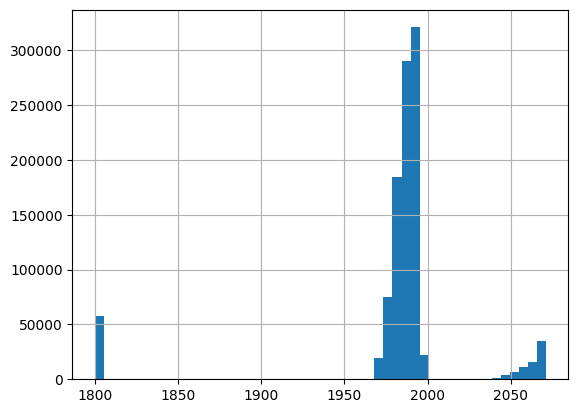

In [4]:
tras.CustomerDOB.dt.year.hist(bins=50)

We can see 
1. people being born in the future => millanium bug
2. people being born in 1800 => we consider there DOB to be unknown

In [5]:
tras.loc[tras.CustomerDOB.dt.year > 2016, 'CustomerDOB'] = \
tras.loc[tras.CustomerDOB.dt.year > 2016, 'CustomerDOB']\
- pd.DateOffset(years = 100)

In [6]:
tras.loc[tras.CustomerDOB.dt.year == 1800, "CustomerDOB"] = pd.NaT

<AxesSubplot: >

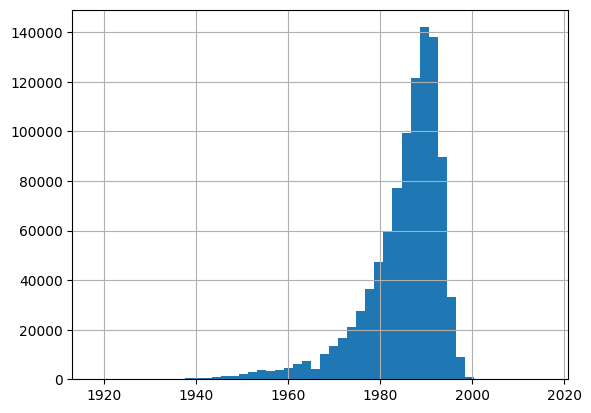

In [7]:
tras.CustomerDOB.dt.year.hist(bins=50)

In [8]:
from datetime import datetime
tras.TransactionTime = tras.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

Missing values are not too many, so we drop them

In [9]:
print('NA rows:',tras.isna().any(axis=1).sum() / tras.shape[0])
tras.dropna(inplace=True)

NA rows: 0.0603156498344884


We now create a new feature that describes the age of the customer when doing the transaction

In [10]:
tras['CustomerAge'] = ((tras.TransactionDate - tras.CustomerDOB).dt.days / 365).round().astype(int)

### Locations
___
We notice that the locations are many and it may be difficult to handle all of them, so we try to clean them up and reduce the number of them, also because many of them are specifications of others, such as `MUMBAI` and `NAVI MUMBAI`.

In [11]:
tras.CustLocation.unique().size

8164

Removing punctuation

In [46]:
import re
tras['CleanLocation'] =\
    tras.CustLocation.apply(lambda loc : re.sub(r'[^\w\s]', '', loc))

Now for every location we search for a shorter name that is present in the dataset. We check if the shorter version is a sub-string of the original name, if yes then we consider it to be the same location.

Also if a city is not very frequent (less than 40 occurences) we assign it to `OTHER`.

In [50]:
unique_locations = tras.CleanLocation.value_counts()
POPULARITY_THRESHOLD = 40
popular_locations =  unique_locations[unique_locations > POPULARITY_THRESHOLD]
unpopular_locations = unique_locations[unique_locations <= POPULARITY_THRESHOLD]

def clean(city):
    parts = city.split()

    for p in parts:
        if p in popular_locations.index:
            return p
        
    return 'OTHER'

mapping = dict(zip(unpopular_locations.index, unpopular_locations.index.map(clean)))
tras.CleanLocation = tras.CleanLocation.map(lambda c: mapping[c] if c in mapping.keys() else c)

We observe that we have succesfully reduced the size of the unique values, by a factor of 10.

In [51]:
tras.CleanLocation.unique().size

962

## 2.1.2 Group by customers

We need to obtain the following features for each customer out of our original dataset:
- Number of transactions
- Number of transactions with a balance bigger than 100 USD
- Average amount of the transactions
- Average balance
- Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).
- Most common gender of the customer
- Most frequent location of the customer


In [53]:
# Most frequent Age, Gender and Location
custs = tras \
    .groupby('CustomerID')[['CustomerAge', 'CustGender', 'CleanLocation']] \
    .agg(lambda col: col.mode()[0])

# Average of transaction amount and balance
custs[['CustAccountBalance_avrg', 'TransactionAmount_avrg (INR)']] = \
    tras.groupby('CustomerID')[['CustAccountBalance', 'TransactionAmount (INR)']].mean()

# Number of transactions
custs['TransactionNum'] = tras.groupby('CustomerID')['TransactionAmount (INR)'].count()

# Number of transactions over 100 INR dollars
custs['TransactionNumGT100'] = tras.loc[tras['TransactionAmount (INR)'] > 100].groupby('CustomerID')['TransactionAmount (INR)'].count()
custs.TransactionNumGT100.fillna(0, inplace=True)
custs.TransactionNumGT100 = custs.TransactionNumGT100.astype(int)

# Utilisation
tras['utilisation'] = tras.CustAccountBalance - tras['TransactionAmount (INR)']
custs['utilisation'] = tras.groupby('CustomerID')['utilisation'].mean()

custs.to_csv('customers.tsv', sep="\t")
custs.head()

## 2.1.3 Engineer new features

We have to extract some new features out of our original dataset. We picked the following features:
- Most frequent day of week
- Ever transactioned on weekend

In [109]:
custs['dayOfWeek_Mode'] = tras.groupby('CustomerID')['TransactionDate'].agg(lambda d: d.dt.day_name().mode()[0])
custs['weekend'] = tras.groupby('CustomerID', sort=False)['TransactionDate'].agg(lambda d: any(d.dt.dayofweek >= 5) )

- Average time between transactions

In [103]:
custs['avg_period'] = tras.groupby('CustomerID')['TransactionDate'].agg(lambda d: ((d.max() - d.min()) / d.count()).total_seconds())

- Was ever in negative balance

In [94]:
custs['NegativeBalance'] = tras[tras.CustAccountBalance <= 0].groupby('CustomerID')['CustAccountBalance'].count()
custs['NegativeBalance'].fillna(0, inplace=True)

- Maximum expense over balance in one transaction
- Mean expense over balance in one transaction

In [170]:
tras['impact'] = (tras['TransactionAmount (INR)'] +.1)/ (tras.CustAccountBalance +1)
custs[['MaxImpact', 'AvgImpact']] = tras.groupby('CustomerID')['impact'].agg([max, 'mean'])

- Max Transaction
- Min Transaction
- Median Transaction
- 25-percentile Transaction
- 75-percentile Transaction
- Standeard Deviation of Transaction

In [107]:
from functions import percentile
custs[[
    'Max Transaction', 'Min Transaction', 
    'Median Transaction', '25-percentile Transaction', 
    '75-percentile Transaction', 'Standard Deviation Transaction']] \
    = tras.groupby('CustomerID')['TransactionAmount (INR)'] \
        .agg([max, min, 'median', percentile(25), percentile(75), 'std'])

- Median Balance
- Max Balance
- Min Balance
- Standard Deviation of Balance

In [112]:
custs[[
    'Median Balance', 'Max Balance', 
    'Min Balance', 'Standard Deviation Balance']] \
    = tras.groupby('CustomerID', sort=False)['CustAccountBalance']\
        .agg(['median', max, min, 'std'])\
custs.fillna(0, inplace=True) # need to fill the NA values of the standard deviation with only one transaction

- Season of birth
- Decade of birth

In [126]:
SEASONS = {0: 'Winter', 1:'Spring', 2:'Summer',3:'Fall'}
custs['seasonDOB'] = tras.groupby('CustomerID')['CustomerDOB'].agg('first').map(lambda dob: (dob.month - 1) // 3 ).map(SEASONS)

custs['decadeDOB'] = tras.groupby('CustomerID')['CustomerDOB'].agg('first').map(lambda dob: str(dob.year//10 * 10))

- Most frequent period of day (morning, noon, evening and night)
- Ever transactioned at night

In [133]:
DAY_PERIOD = {0: 'Night', 1: 'Morning', 2:'Afternoon', 3:'Evening'}
tras['transaction_period'] = tras.TransactionTime.map(lambda time: time.hour // 6).map(DAY_PERIOD)
custs['DayPeriodMode'] = tras.groupby('CustomerID')['TransactionTime'].agg(lambda p: p.mode()[0])

custs['NightTransaction'] = tras.groupby('CustomerID', sort=False)['transaction_period'].agg(lambda d: any(d == 'Night') )

### Results:
Finally we can enjoy our new enriched dataset of 27 features, of which:
- 7 categorical
- 20 numerical

In [14]:
custs.to_csv('customers_enriched.csv')
custs.head()

,CustomerAge,CustGender,CleanLocation,CustAccountBalance_avrg,TransactionAmount_avrg (INR),TransactionNum,TransactionNumGT100,utilisation,dayOfWeek_Mode,avg_period,...,25-percentile Transaction,75-percentile Transaction,Standard Deviation of Transaction,weekend,Median Balance,Max Balance,Min Balance,Standard Deviation Balance,seasonDOB,NightTransaction
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,24,F,NEW DELHI,76340.635,2553.0,2,2,73787.635,Monday,777600.0,...,1454.50,3651.50,3107.027197,False,76340.635,120180.54,32500.73,61998.988224,Summer,True
C1010012,22,M,MUMBAI,24204.490,1499.0,1,1,22705.490,Sunday,0.0,...,1499.00,1499.00,0.000000,True,24204.490,24204.49,24204.49,0.000000,Summer,False
C1010014,24,F,MUMBAI,100112.950,727.5,2,2,99385.450,Friday,7862400.0,...,488.75,966.25,675.286976,False,100112.950,161848.76,38377.14,87307.619786,Spring,False
C1010018,26,F,CHAMPARAN,496.180,30.0,1,0,466.180,Thursday,0.0,...,30.00,30.00,0.000000,False,496.180,496.18,496.18,0.000000,Spring,False
C1010024,51,M,KOLKATA,87058.650,5000.0,1,1,82058.650,Thursday,0.0,...,5000.00,5000.00,0.000000,False,87058.650,87058.65,87058.65,0.000000,Spring,False


# 2.2 Pick your features!
Now that we have this many features we want to apply some dimensionality reduction to it, in order to ease the training of our model later.

Since our model has both categorical and numerical features the optimal solution would've been to use the **FAMD** rather than the PCA, but due to shortage of time, and some very decent results, we will pick the **PCA** to decompose our features nonetheless.

We will first perform some preprocessing to our data by making use of the `Pipeline` library of _scikit-learn_, and then apply the PCA.

In [24]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as col_selector
from sklearn.decomposition import PCA

custs = pd.read_csv('customers_enriched.csv', index_col='CustomerID')

## Build the Pipeline
Now we build the Pipeline that will handle our preprocessing:
- An `OrdinalEncoder` for the **categorical** columns. While this is not optimal we notice that we still obtain some good results with it. 
- A `MinMaxScaler` for all the columns, as the PCA works so much better with scaled values, because otherwise values which have much higher variance might greatly influence the overall variance.
Then we will pass everything into the PCA and we will select as many features as to guaranteee that at least 70% of the variance is covered

In [8]:
preprocess = make_column_transformer(
    (OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1,
        # min_frequency=1e-3,
        ),col_selector(dtype_exclude=np.number)),
    ('passthrough', col_selector(dtype_include=np.number))
)
pipe = make_pipeline(
    preprocess,
    MinMaxScaler(),
    PCA(n_components=10)
)

pipe.fit(custs)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc46de2a3b0>),
                                                 ('passthrough', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc46de2a4a0>)])),
                ('minmaxscaler', MinMaxScaler()),
                ('pca', PCA(n_components=10))])

## Pick the optimal number of features
Finally we see how many features we need to explain the variability of at least 70% of the data.

In [9]:
n_features = 0
pca_variance = pipe.named_steps['pca'].explained_variance_ratio_
# pca_variance = pipe.explained_inertia_

for i in range(1,len(pca_variance)+1):
    variance_explained = pca_variance[:i].sum()
    print(f'{i:2} features explain {round(variance_explained*100,1)}% of the data')
    if n_features == 0 and variance_explained > .7:
        n_features = i    

 1 features explain 27.5% of the data
 2 features explain 52.6% of the data
 3 features explain 69.2% of the data
 4 features explain 82.0% of the data
 5 features explain 89.6% of the data
 6 features explain 95.5% of the data
 7 features explain 98.0% of the data
 8 features explain 98.9% of the data
 9 features explain 99.6% of the data
10 features explain 99.9% of the data


And we can save the new features as csv.

In [11]:
X = pipe.transform(custs)

reducted_data = pd.DataFrame(X)
# Take only most important features
reducted_data = reducted_data.iloc[:,:n_features]
reducted_data.index = custs.index
reducted_data.to_csv('reducted_data.csv')
reducted_data.head()

,0,1,2,3
CustomerID,,,,
C1010011,0.032457,0.722161,0.177405,-0.380639
C1010012,0.493733,-0.514476,0.152509,0.208996
C1010014,0.098465,0.744928,-0.153900,-0.551840
C1010018,-0.104101,0.783404,-0.151967,0.111778
C1010024,-0.448586,-0.163735,-0.173863,0.094351


# 2.3 Clustering!
We will implement K-means through MapReduce and try to get the optimal number of clusters, then we will compare the results with `scikit`'s KMeans++.

We start by importing the necessary libraries and setup of `pyspark`.

In [2]:
# Setup pyspark
# ! sudo apt-get update
# ! sudo mkdir -p /usr/share/man/man1
# ! sudo apt-get install -y openjdk-11-jdk
# ! pip install pyspark
import pyspark
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

%load_ext autoreload
%autoreload 2

We can visualize in part our dataset by plotting some of the dimensions.

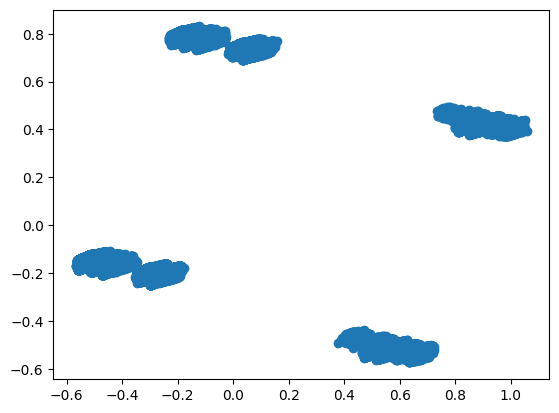

In [3]:
reducted_data = pd.read_csv('reducted_data.csv', index_col='CustomerID')
X = reducted_data.to_numpy()

plt.scatter(X[:, 0], X[:, 1])
plt.show()

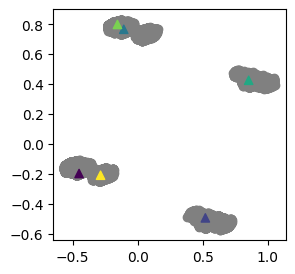

Exception in thread "serve RDD 26" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


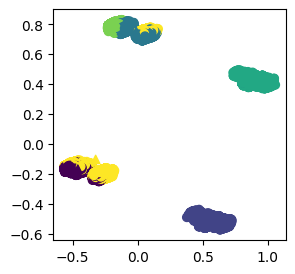

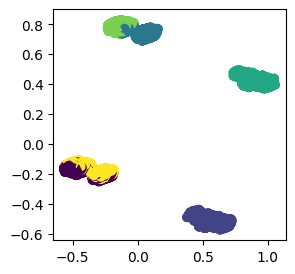

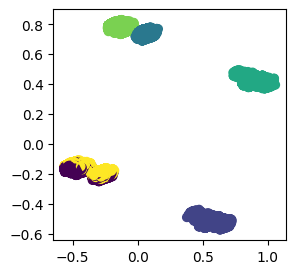

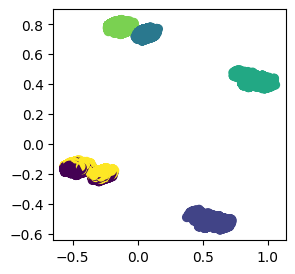

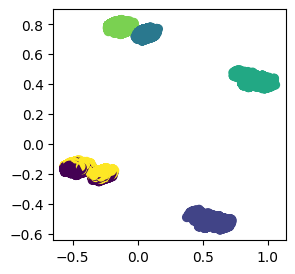

In [20]:
from functions import k_means, display_clusters
y, means = k_means(X,6, display=True, early_stopping=1e-5)

In [8]:
from functions import avg_inter_cluster_distance, avg_intra_cluster_distance
avg_inter_cluster_distance(X,y,means), avg_intra_cluster_distance(X,y,means)

(7.106274092123888, 1.9580357021555201)

We can now start the search for the optimal value of **K**. We will do by grid searching through the values $[2,11]$.

In [9]:
Y = []
means = []
K_VALUES = range(2,11)
for k in K_VALUES:
    y, mean = k_means(X,k, display=False)
    Y.append(y)
    means.append(mean)
    
Y = np.stack(Y)

Text(0.5, 0, 'k')

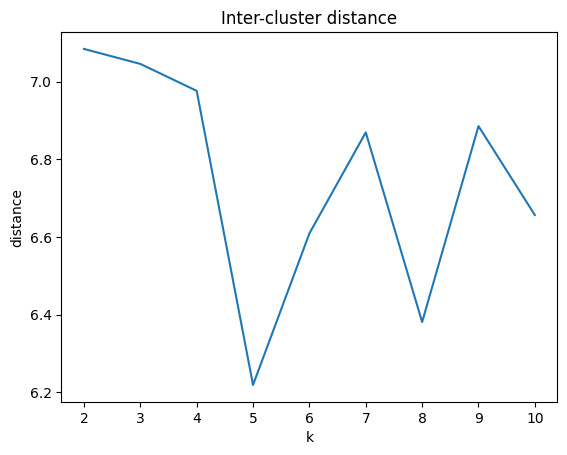

In [10]:
avg_inter_elbow = elbow(avg_inter_cluster_distance, X, Y, means, K_VALUES)
plt.plot(avg_inter_elbow.keys(), avg_inter_elbow.values())
plt.title('Inter-cluster distance')
plt.ylabel('distance')
plt.xlabel('k')

Text(0.5, 0, 'k')

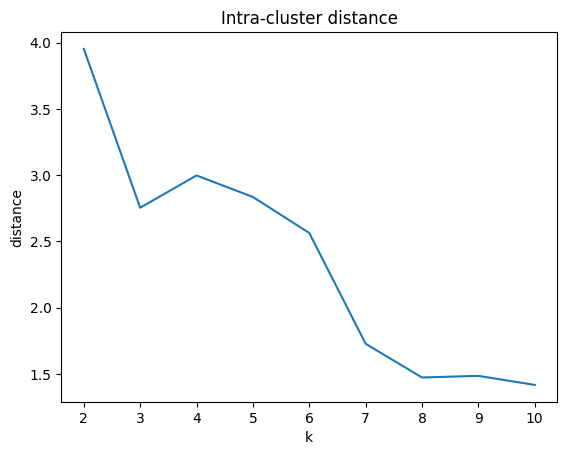

In [11]:
avg_intra_elbow = elbow(avg_intra_cluster_distance, X, Y, means, K_VALUES)
plt.plot(avg_intra_elbow.keys(), avg_intra_elbow.values())
plt.title('Intra-cluster distance')
plt.ylabel('distance')
plt.xlabel('k')

So now we can choose the optimal k.

In [21]:
OPTIMAL_K = 6
y_optimal = Y[OPTIMAL_K - 2] # starts from 2

### Compare against scikit
Now we can confront our algorithm with the KMeans++ from `scikit`

Exception in thread "serve RDD 1" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


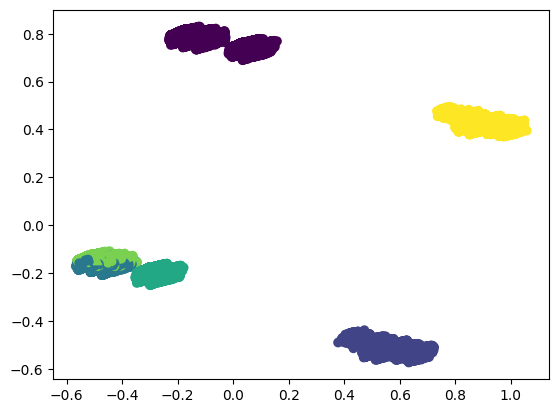

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=OPTIMAL_K).fit(X)
display_clusters(X, kmeans.labels_, kmeans.cluster_centers_)

In [17]:
Y_sk = []
means_sk = []
K_VALUES = range(3,20)
for k in K_VALUES:
    km = KMeans(n_clusters=k).fit(X)
    Y_sk.append( km.labels_ )
    means_sk.append( km.cluster_centers_ )
    
Y_sk = np.stack(Y_sk)

Text(0.5, 0, 'k')

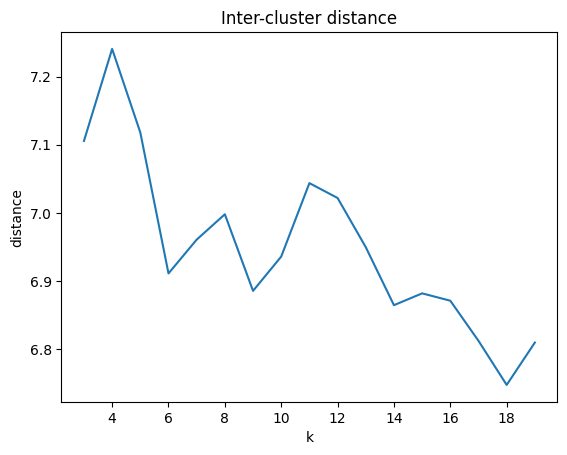

In [18]:
avg_inter_elbow = elbow(avg_inter_cluster_distance, X, Y_sk, means_sk, K_VALUES )
plt.plot(avg_inter_elbow.keys(), avg_inter_elbow.values())
plt.title('Inter-cluster distance')
plt.ylabel('distance')
plt.xlabel('k')

Text(0.5, 0, 'k')

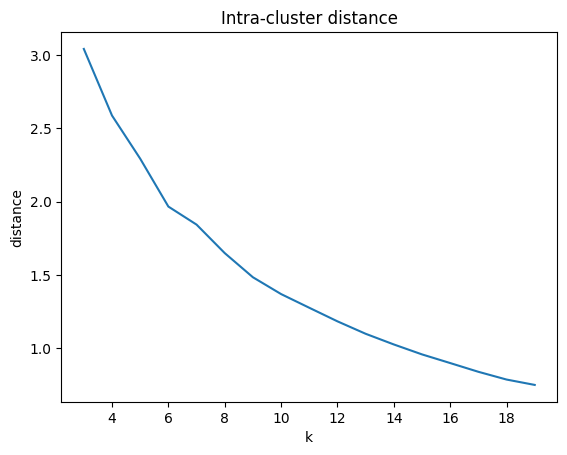

In [20]:
avg_intra_elbow = elbow(avg_intra_cluster_distance, X, Y_sk, means_sk, K_VALUES )
plt.plot(avg_intra_elbow.keys(), avg_intra_elbow.values())
plt.title('Intra-cluster distance')
plt.ylabel('distance')
plt.xlabel('k')

# 2.4 Characterizing Clusters

In [29]:
from sklearn.preprocessing import KBinsDiscretizer
from functions import pivot
custs['cluster'] = y_optimal

pd.set_option('display.max_columns', None)
custs.select_dtypes(include=np.number).groupby('cluster').agg([min, 'median','mean', max])

CustomerAge                       CustAccountBalance_avrg             \
                min median       mean max                     min     median   
cluster                                                                        
0                 0   29.0  31.143391  97                     0.0  14604.355   
1                 1   28.0  30.462304  96                     0.0  17925.180   
2                 2   27.0  29.481271  99                     0.0  21782.840   
3                 4   27.0  29.231982  97                     0.0  24192.600   
4                 1   28.0  30.196206  97                     0.0  20494.870   
5                 0   29.0  30.610168  94                     0.0  15480.650   

                                     TransactionAmount_avrg (INR)              \
                  mean           max                          min      median   
cluster                                                                         
0        107245.873860  1.150355e+08                          0.0  394.000000   
1        112914.908653  1.150355e+08                          0.0  495.821667   
2         99035.031641  8.224463e+07                          0.0  525.595000   
3        104560.686632  8.224463e+07                          0.0  624.852500   
4        101099.503427  8.224463e+07                          0.0  504.000000   
5        102263.161358  6.979933e+07                          0.0  400.000000   

                                 TransactionNum                       \
                mean         max            min median      mean max   
cluster                                                                
0        1396.714351   991132.22              1    1.0  1.074206   5   
1        1428.407446   561001.00              1    1.0  1.251370   6   
2        1571.584657  1380002.88              1    1.0  1.253454   5   
3        1598.458099   569500.27              1    1.0  1.365550   6   
4        1567.346564   720001.16              1    1.0  1.114594   6   
5        1373.792286  1560034.99              1    1.0  1.121426   5   

        TransactionNumGT100                      utilisation              \
                        min median      mean max         min      median   
cluster                                                                    
0                         0    1.0  0.838926   5  -907524.12  13625.4050   
1                         0    1.0  1.006066   6  -551676.65  16926.6150   
2                         0    1.0  1.031084   5 -1281342.55  20558.9200   
3                         0    1.0  1.147012   5  -530765.10  22858.6525   
4                         0    1.0  0.921551   5  -705823.51  19394.2200   
5                         0    1.0  0.881014   5 -1517547.10  14521.2450   

                                     avg_period                       \
                  mean           max        min median          mean   
cluster                                                                
0        105849.159508  1.150339e+08        0.0    0.0  2.434761e+05   
1        111486.501207  1.150308e+08        0.0    0.0  7.308014e+05   
2         97463.446984  8.224272e+07        0.0    0.0  9.877050e+05   
3        102962.228533  8.224326e+07        0.0    0.0  1.231543e+06   
4         99532.156862  8.224303e+07        0.0    0.0  4.043966e+05   
5        100889.369072  6.977698e+07        0.0    0.0  4.298881e+05   

                    NegativeBalance                           MaxImpact  \
                max             min median      mean  max           min   
cluster                                                                   
0        14515200.0             0.0    0.0  0.002149  1.0  7.277259e-09   
1        14472000.0             0.0    0.0  0.002719  2.0  3.816097e-08   
2        14515200.0             0.0    0.0  0.002453  2.0  7.483844e-08   
3        14472000.0             0.0    0.0  0.002917  2.0  2.362088e-07   
4        13089600.0             0.0    0.0  0.001

We decide to pick `CustGender`, `MaxImpact` and `CustAccounBalance_avrg`, so we discretize them into 4 categories: Low, Mid-Low, Mid-High, High based on percentiles.

In [34]:
custs[['MaxImpact_d', 'BalanceAvg_d']] = KBinsDiscretizer(n_bins=4, subsample=None, encode='ordinal').fit_transform(custs[['MaxImpact', 'CustAccountBalance_avrg']])
mapping = {0:'Low', 1:'Mid-Low', 2:'Mid-High', 3:'High'}
custs[['MaxImpact_d', 'BalanceAvg_d']] = custs[['MaxImpact_d', 'BalanceAvg_d']].replace(mapping)

,MaxImpact_d,BalanceAvg_d,CustGender
CustomerID,,,
C1010011,Mid-High,High,F
C1010012,Mid-High,Mid-High,M
C1010014,Mid-Low,High,F
C1010018,Mid-High,Low,F
C1010024,Mid-High,High,M


We then look at the pivot tables, and notice that:
- The gender of a customer is a perfect cut between a Cluster and another
- Cluster 1 appears to include richer people 
- while 0 and 5 contain poorer people, and also people who tend to spend less in comparatively with the amount of money they have ( low impact )

In [91]:
pivot(custs, 'CustGender')

CustGender,F%,M%
cluster,,
0,0.0,100.0
1,100.0,0.0
2,0.0,100.0
3,100.0,0.0
4,0.0,100.0
5,0.0,100.0
6,100.0,0.0


In [92]:
pivot(custs, 'BalanceAvg_d')

BalanceAvg_d,High%,Low%,Mid-High%,Mid-Low%
cluster,,,,
0,22.4,28.9,23.5,25.2
1,29.5,17.5,28.5,24.5
2,25.4,24.9,24.9,24.8
3,27.6,20.6,27.0,24.8
4,23.2,27.6,23.9,25.3
5,22.8,29.4,22.7,25.1
6,27.0,20.8,27.2,25.0


In [93]:
pivot(custs, 'MaxImpact_d')

MaxImpact_d,High%,Low%,Mid-High%,Mid-Low%
cluster,,,,
0,23.8,27.0,23.8,25.4
1,26.9,20.7,27.8,24.6
2,26.5,23.5,25.5,24.4
3,23.5,25.5,25.5,25.5
4,25.4,25.5,24.2,24.8
5,24.1,27.3,23.5,25.1
6,23.3,25.1,25.8,25.8


# Bonus
First we try the Gaussian Mixture model for clustering. It's a very fast algorithm, and works by fitting multiple Gaussians into the data, trying to reduce as much as possible the error. As it can be seen it's still very initialization dependent, and the wrong initialization could, and probably will, hand out wrong results.

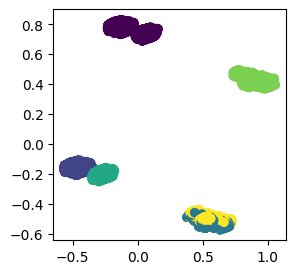

In [15]:
from sklearn.mixture import GaussianMixture

gauss = GaussianMixture(n_components=OPTIMAL_K).fit(X)
display_clusters(X, gauss.predict(X), gauss.means_)

The next algorithm that we will try is the **Birch** algorithm, which can perfectly clusterize put dataset, with no problems about random initialization.

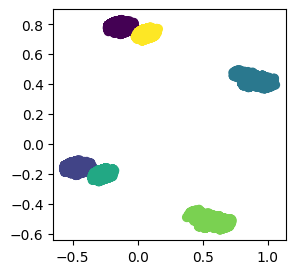

In [30]:
from sklearn.cluster import Birch

birch = Birch(n_clusters=OPTIMAL_K).fit(X)
display_clusters(X, birch.labels_)